# Homework: Basic Artificial Neural Networks

The goal of this homework is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design of was heavily inspired by [Torch](http://torch.ch) which is the most convenient neural network environment when the work involves defining new layers. 

This homework requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- homework_modules.ipynb
- homework_differentiation.ipynb

In [85]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from sklearn.preprocessing import OneHotEncoder

# Framework

Implement everything in `Modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [268]:
# (re-)load layers
%run homework_modules.ipynb

Optimizer is implemented for you. 

In [30]:
def sgd_momentum(x, dx, config, state):
    """
        This is a very ugly implementation of sgd with momentum 
        just to show an example how to store old grad in state.
        
        config:
            - momentum
            - learning_rate
        state:
            - old_grad
    """
    
    # x and dx have complex structure, old dx will be stored in a simpler one
    state.setdefault('old_grad', {})
    i = 0 
    #print(dx[0])
    for cur_layer_x, cur_layer_dx in zip(x,dx): 
        for cur_x, cur_dx in zip(cur_layer_x,cur_layer_dx):

            cur_old_grad = state['old_grad'].setdefault(i, np.zeros_like(cur_dx))
            np.add(config['momentum'] * cur_old_grad, config['learning_rate'] * cur_dx, out = cur_old_grad)
        
            cur_x -= cur_old_grad
            i += 1     

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

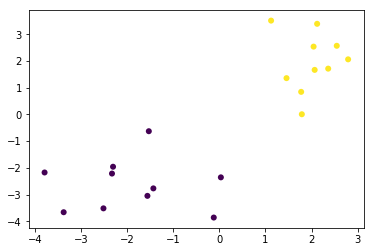

In [41]:
# Generate some data
N = 10

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [285]:
# (re-)load layers
%run homework_modules.ipynb
net = Sequential()

#
net.add(Linear(X.shape[1],2))
#net.add(ReLU())
net.add(SoftPlus())
#criterion = MSECriterion()
criterion = ClassNLLCriterionUnstable()

print(net)


Linear 784 -> 2
SoftPlus



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [109]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}


# Looping params
n_epoch = 20
batch_size = 128

In [110]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

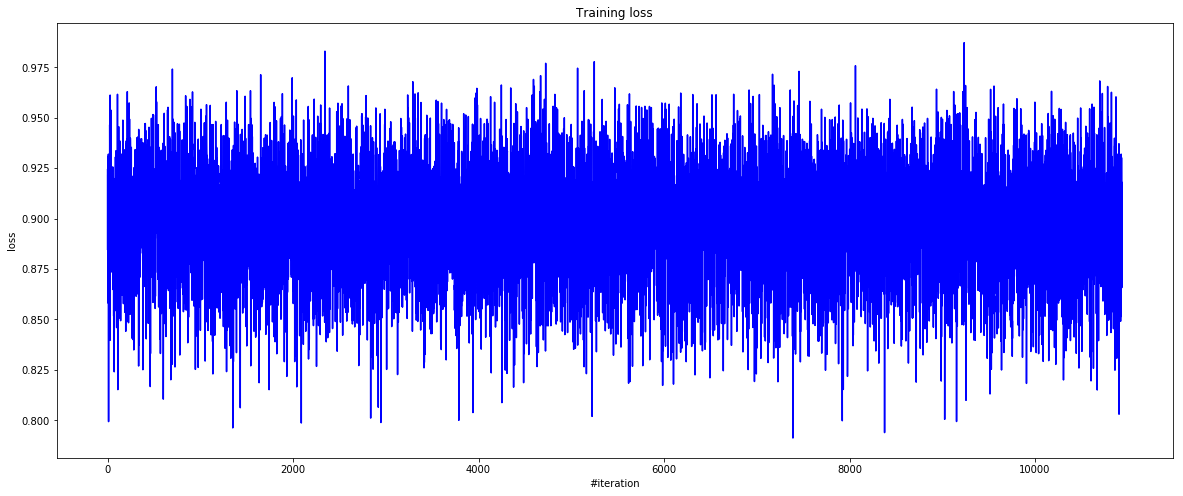

Current loss: 0.876647


In [151]:
loss_history = []
optimizer_state = {}
for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
        
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(20, 8))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

In [175]:
def train_foo( X, Y, net, loss_history, optimizer_state, optimizer_config,
              n_epoch , batch_size):
    
    for i in range(n_epoch):
        for x_batch, y_batch in get_batches((X, Y), batch_size):
        
            net.zeroGradParameters()
        
            # Forward
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)
        
    
        # Backward
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)
        
        # Update weights
            sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

        # Visualize
        display.clear_output(wait=True)
        plt.figure(figsize=(8, 6))
        
        plt.title("Training loss")
        plt.xlabel("#iteration")
        plt.ylabel("loss")
        plt.plot(loss_history, 'b')
        plt.show()
    
        print('Current loss: %f' % loss)   
    

# Digit classification 

We are using [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset. Lets start with [cool visualization](http://scs.ryerson.ca/~aharley/vis/). The most beautiful demo is the second one, if you are not familiar with convolutions you can return to it in several lectures. 

In [280]:
import os
from sklearn.datasets import fetch_mldata

# Fetch MNIST dataset and create a local copy.
if os.path.exists('mnist.npz'):
    with np.load('mnist.npz', 'r') as data:
        X = data['X']
        y = data['y']
else:
    mnist = fetch_mldata("mnist-original")
    X, y = mnist.data / 255.0, mnist.target
    np.savez('mnist.npz', X=X, y=y)

 One-hot encode the labels first.

In [281]:
# Your code goes here. ################################################
ohe = OneHotEncoder(n_values = 10, sparse=False)
Y = ohe.fit_transform(y.reshape(-1, 1))


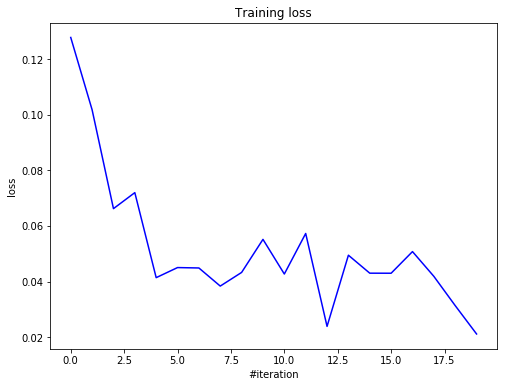

Current loss: 0.021138


In [278]:
# Your code goes here. ################################################
loss_history = []
optimizer_state = {}
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}

net = Sequential()
net.add(Linear(X.shape[1],100))
net.add(LeakyReLU())
net.add(Linear(100,10))
net.add(LeakyReLU())

criterion = MSECriterion()
#criterion = ClassNLLCriterionUnstable()

train_foo(X, Y, net, loss_history, optimizer_state, 
          optimizer_config,n_epoch, batch_size)

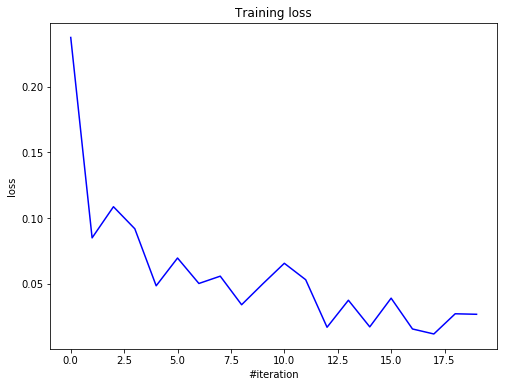

Current loss: 0.026943


In [282]:
# Your code goes here. ################################################
loss_history = []
optimizer_state = {}
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}

net = Sequential()
net.add(Linear(X.shape[1],200))
net.add(LogSigm())
net.add(Linear(200,100))
net.add(LeakyReLU())
net.add(Linear(100,10))
net.add(LeakyReLU())

criterion = MSECriterion()
#criterion = ClassNLLCriterionUnstable()

train_foo(X, Y, net, loss_history, optimizer_state, 
          optimizer_config,n_epoch, batch_size)

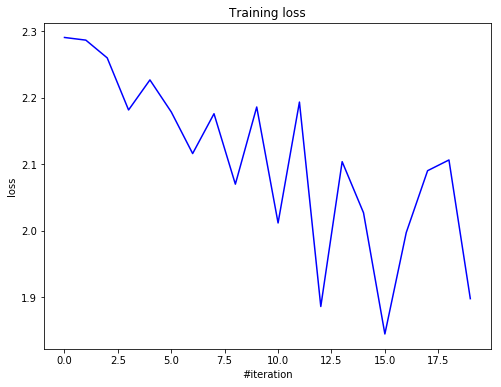

Current loss: 1.898225


In [284]:
# Your code goes here. ################################################
loss_history = []
optimizer_state = {}
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}

net = Sequential()
net.add(Linear(X.shape[1],100))
net.add(SoftMax())

net.add(Linear(100,10))
net.add(SoftMax())

#criterion = MSECriterion()
criterion = ClassNLLCriterionUnstable()

train_foo(X, Y, net, loss_history, optimizer_state, 
          optimizer_config,n_epoch, batch_size)

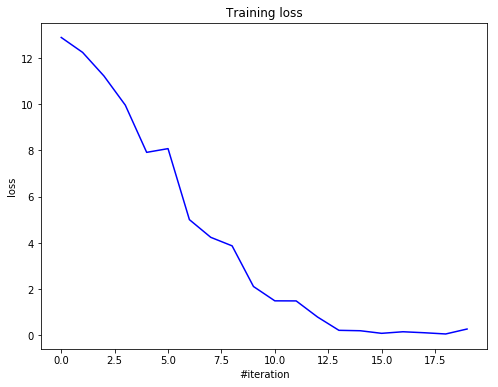

Current loss: 0.276614


In [212]:
# Your code goes here. ################################################
loss_history = []
optimizer_state = {}
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
n_epoch = 20
batch_size = 128


net = Sequential()
net.add(Linear(X.shape[1],40))
net.add(SoftPlus())
net.add(Linear(40,10))
net.add(SoftPlus())


#criterion = MSECriterion()
criterion = ClassNLLCriterionUnstable()

train_foo(X, Y, net, loss_history, optimizer_state, 
          optimizer_config,n_epoch, batch_size)

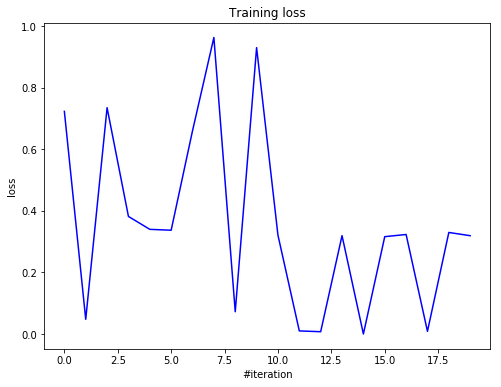

Current loss: 0.319247


In [216]:
# Your code goes here. ################################################
loss_history = []
optimizer_state = {}
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
n_epoch = 20
batch_size = 128

net = Sequential()
net.add(Linear(X.shape[1], 100))
net.add(LeakyReLU())
net.add(Linear(100, 10))
net.add(LeakyReLU())

criterion = ClassNLLCriterionUnstable()

train_foo(X, Y, net, loss_history, optimizer_state, 
          optimizer_config,n_epoch, batch_size)

Print here your accuracy. It should be around 90%.

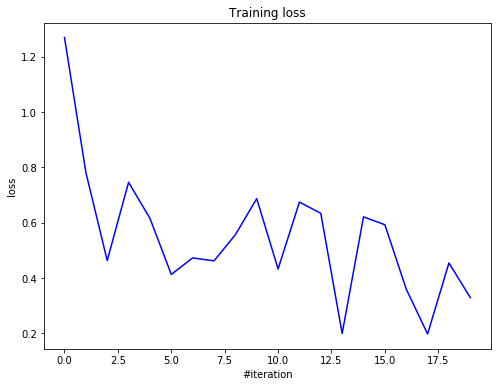

Current loss: 0.329438


In [256]:
#
# Your code goes here. ################################################
loss_history = []
optimizer_state = {}
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
n_epoch = 20
batch_size = 128

net = Sequential()
net.add(Linear(X.shape[1], 250))
net.add(Dropout(p = 0.1))
net.add(Linear(250, 100))
net.add(LeakyReLU())
net.add(Linear(100, 10))
net.add(LogSigm())

criterion = ClassNLLCriterionUnstable()

train_foo(X, Y, net, loss_history, optimizer_state, 
          optimizer_config,n_epoch, batch_size)

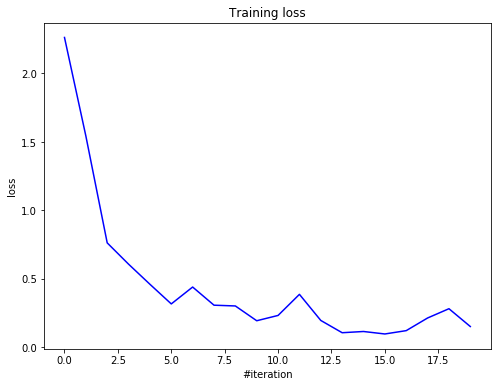

Current loss: 0.152583


In [241]:
# # Your code goes here. ################################################
loss_history = []
optimizer_state = {}
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
n_epoch = 20
batch_size = 128

net = Sequential()
net.add(Linear(X.shape[1], 100))
net.add(LogSigm())
net.add(Linear(100, 50))
net.add(LogSigm())
net.add(Linear(50, 10))
net.add(LogSigm())

criterion = ClassNLLCriterionUnstable()

train_foo(X, Y, net, loss_history, optimizer_state, 
          optimizer_config,n_epoch, batch_size)